# Chapter 8 Conditional Manatees

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

# 8.0 Introduction

- 故事1
  - 海牛（Trichechus manatus）是一种移动缓慢的水生哺乳动物，生活在温暖的浅水区。海牛没有天敌，但它们与机动船共享水域。而机动船有螺旋桨，螺旋桨叶片可以而且确实可以杀死它们。大多数成年海牛都有某种与船相撞后留下的伤疤。
- 故事2
  - 阿姆斯特朗-惠特沃斯A.W.38惠特利是皇家空军的前线轰炸机。在第二次世界大战期间，A.W.38携带炸弹和小册子进入德国境内。与海牛不同，A.W.38有激烈的天敌：火炮和拦截机的火力。许多飞机在执行任务后再也没有回来。而那些幸存下来的飞机都有伤痕为证。
- 海牛的螺旋桨伤痕和轰炸机的弹痕在某种程度上有一定的相似性，现在我们想做一件事情：<font color=Blue>帮助海牛和轰炸机生存。</font>
  - 对于海牛来说，这可能意味着需要螺旋桨防护（在船上，而不是在海牛身上）。
  - 对于轰炸机来说，这意味着在飞机上显示出最多损害的部分增加装甲。
- 但其实故事本身就在一开始欺骗了我们，事实是：
  - 螺旋桨并没有造成海牛的大部分伤害和死亡。相反，尸检证实，与船的钝器（如龙骨）相撞，造成的损害要大得多。
  - 同样，对返回的轰炸机的受损部分进行升级装甲，也没有什么好处。
  - 从幸存的海牛和轰炸机上获得的证据具有误导性，因为它是以生存为前提的。海牛和轰炸机死亡的情况不同。一只被龙骨击中的海牛比另一只被螺旋桨擦伤的海牛更不可能活下来。所以在幸存者中，螺旋桨的伤痕很常见。同样，返回家园的轰炸机明显地没有驾驶舱和发动机的损坏。他们是幸运的。那些从未回国的轰炸机就没那么幸运了。为了得到正确的答案，无论在哪种情况下，我们都必须认识到，所看到的那种损害是以生存为条件的。  

- <h3><font color="red">幸存者偏差→Conditioning→Complex conditioning→Interaction</font></h3>

# 8.1 Building an interaction

- Africa is geographically special, in a puzzling way: Bad geography tends to be related to bad economies outside of Africa, but African economies may actually benefit from bad geography.
  - 如Code8.1图所示，非洲的国家与世界上的大部分国家相反，其地理环境(ruggedness)越差，其GDP越高。
  - 这非常地反常识，因为糟糕的地理环境会使交通更加地困难，包括商品运输，进而负向地影响其经济。
  - 并不能这么简单地思考这件事情，上述的因果推断很可能是错的，回想<font color=blue>Chapter 6</font>的知识，其中指不定会有一些未观察到的变量。
  - 画出DAG图: R为ruggedness，C为continent，G为GDP，U为unobserved confounds  
    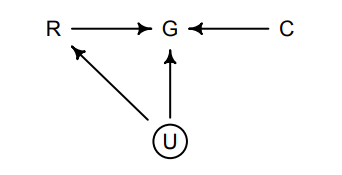
  - 若暂时不关注U，仅用R和C预测G，即$G=f(R,C)$
  - 但该DAG并未反映R与C的交互作用(interaction: one moderates the influence of the other)
  -   <font color=Red>**Question**：我们该建立怎样的模型去描述这种交互呢？</font>
      -   一种直观的方法是将数据集划分为Africa数据集和Other continents数据集，然后分别去训练模型，但此方法并不科学
- <font color=Red>接下来主要将如何采用一个模型就能够复现Code8.1所代表的两个模型</font>
  - 但我感觉下面的步骤其实跟直接将数据集分割再分别训练无异，可能是采用的模型太简单了，若是如下图更复杂的模型，则不是这么一回事了
  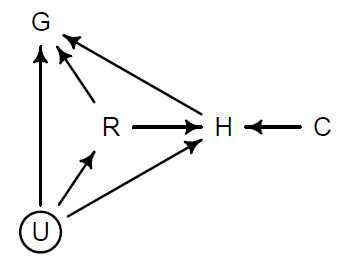

#### Code 8.1: 将logGDP标准化，将rugged除以其最大值

In [3]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

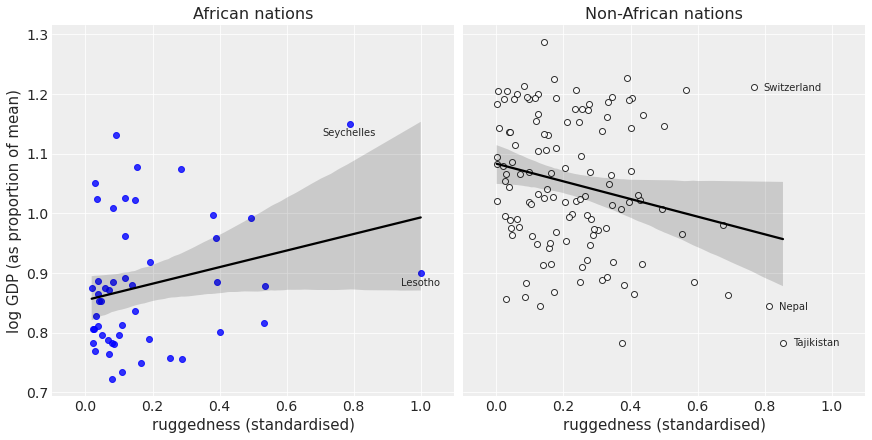

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.regplot(
    dd.loc[dd["cont_africa"] == 1]["rugged_std"],
    dd.loc[dd["cont_africa"] == 1]["log_gdp_std"],
    scatter_kws={"color": "b"},
    line_kws={"color": "k"},
    ax=axs[0],
)
sns.regplot(
    dd.loc[dd["cont_africa"] == 0]["rugged_std"],
    dd.loc[dd["cont_africa"] == 0]["log_gdp_std"],
    scatter_kws={"edgecolor": "k", "facecolor": "w"},
    line_kws={"color": "k"},
    ax=axs[1],
)

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

# label countries
for _, africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 1)].iterrows():
    axs[0].text(
        africa["rugged_std"],
        africa["log_gdp_std"] - 0.02,
        africa["country"],
        ha="center",
    )

for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["log_gdp_std"],
        non_africa["country"],
        va="center",
    )

for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

## 8.1.1 Making a rugged model

- 不考虑continent，使用所有数据创建如下模型m8.1
  $$\begin{aligned}
  \operatorname{log}(y_{i})& \sim\text{Normal}(\mu_i,\sigma)  \\
  \mu_i& =\alpha+\beta(r_i-\bar{r}) \\
  \alpha & \sim\operatorname{Normal}(1,1) \\
  \beta & \sim\operatorname{Normal}(0,1)
  \end{aligned}$$
  - where $y_{i}$ is GDP for nation $i$, $r_i$ is terrain ruggedness for nation $i$, and $\bar{r}$ is the average ruggedness in the whole sample. Its value is 0.215—most nations aren’t that rugged. 
  - 由于$y_{i}$和$r_i$是经过预处理的(Code8.1)，因此$\alpha$的均值应为1，$\beta$的均值为0
  - 但$\alpha$和$\beta$的先验方差是非常粗糙的猜测
  - 如下图左边发现上面的先验假设挺糟糕的，因此经过调整为右边的先验假设并创建新模型m8.1t，Code8.6展示了该模型的信息，发现$\beta$为0，即R与G没有关系  
   $$\begin{aligned}
  \operatorname{log}(y_{i})& \sim\text{Normal}(\mu_i,\sigma)  \\
  \mu_i& =\alpha+\beta(r_i-\bar{r}) \\
  \alpha & \sim\operatorname{Normal}(1,0.1) \\
  \beta & \sim\operatorname{Normal}(0,0.3)
  \end{aligned}$$  

  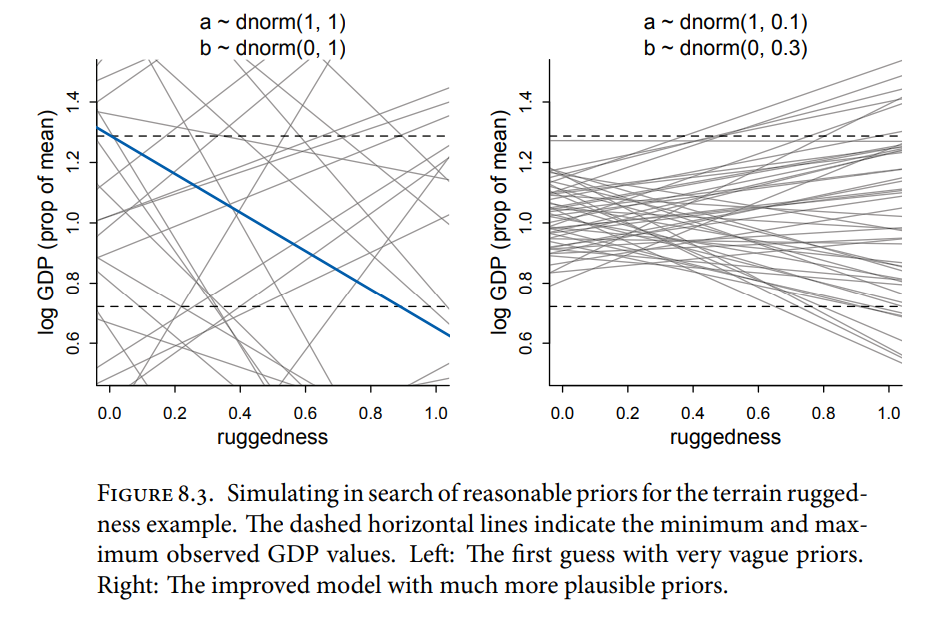

#### Code 8.2

In [5]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

#### Code 8.3

In [6]:
with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive()

# Figure 8.3 is below

#### Code 8.4

In [7]:
beta_prior = az.extract_dataset(m_8_1_prior.prior)["b"].to_numpy()
np.sum(np.abs(beta_prior > 0.6)) / len(beta_prior)

0.26

#### Code 8.5

In [8]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


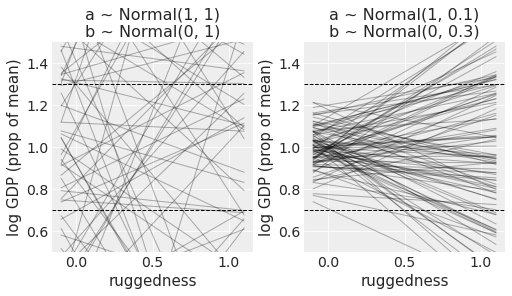

In [9]:
# Figure 8.3

_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1, n)

# Prior 1
prior = m_8_1_prior.prior.sel(draw=slice(None, None, int(len(m_8_1_prior.prior.draw) / n)))
reglines = prior["a"].T.to_numpy() + rugged_plot * prior["b"].T.to_numpy()
for regline in reglines:
    ax1.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

# Prior 2
prior_t = m_8_1t_prior.prior.sel(draw=slice(None, None, int(len(m_8_1t_prior.prior.draw) / n)))
reglines_t = prior_t["a"].T.to_numpy() + rugged_plot * prior_t["b"].T.to_numpy()

for regline in reglines_t:
    ax2.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

#### Code 8.6

In [10]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.08,0.10
sigma,0.14,0.01,0.13,0.15


## 8.1.2  Adding an indicator variable isn’t enough

- 将数据划分为Africa和other continent，创建如下模型m8.2：
  $$\begin{aligned}
  \operatorname{log}(y_{i})& \sim\text{Normal}(\mu_i,\sigma)  \\
  \mu_i&=\alpha_{\mathrm{CID}[i]}+\beta(r_i-\bar{r}) \\
  \alpha & \sim\operatorname{Normal}(1,0.1) \\
  \beta & \sim\operatorname{Normal}(0,0.3)
  \end{aligned}$$  
  

#### Code 8.7

In [11]:
cid = pd.Categorical(dd["cont_africa"])

#### Code 8.8

In [12]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[np.array(cid)] + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


#### Code 8.9: comparision between m8.1t and m8.2, m8.2获得了更低的WAIC

In [13]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace})

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_2,0,-252.289170,4.148160,0.000000,0.969126,14.830860,0.000000,True,deviance
m_8_1t,1,-188.785601,2.613889,63.503569,0.030874,12.939324,14.657746,False,deviance


#### Code 8.10

In [14]:
az.summary(m_8_2_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.06
a[1],0.88,0.02,0.86,0.91
b,-0.05,0.05,-0.12,0.03
sigma,0.11,0.01,0.10,0.12


#### Code 8.11: a[0]与a[1]的差值的89%的兼容区间, 小于0

In [15]:
m_8_2_posterior = az.extract_dataset(m_8_2_trace.posterior)
diff_a0_a1 = m_8_2_posterior["a"][1, :] - m_8_2_posterior["a"][0, :]
az.hdi(diff_a0_a1.to_numpy())

array([-0.19925631, -0.13834038])

#### Code 8.12: 此处获得的结论是weak negative relationship between economic development and ruggedness(仅从均值上看，因为两者的斜率是相同的)

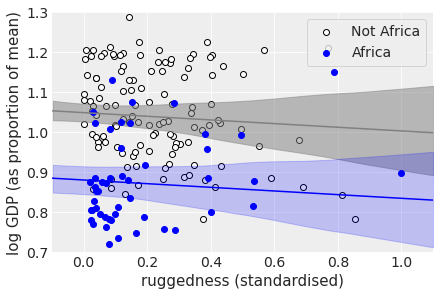

In [16]:
fig, ax = plt.subplots()

# extract posterior samples of parameters
a0 = m_8_2_posterior["a"][0, :].to_numpy()
a1 = m_8_2_posterior["a"][1, :].to_numpy()
b = m_8_2_posterior["b"].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
pred0 = a0 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = a1 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred1.mean(1), color="b")
az.plot_hdi(rugged_plot, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0.7, 1.3)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");

 ## 8.1.3 Adding an interaction does work

  - 进一步(make the slope conditional on continent)建立如下模型m8.3：
  $$\begin{aligned}
  \operatorname{log}(y_{i})& \sim\text{Normal}(\mu_i,\sigma)  \\
  \mu_i&=\alpha_{\mathrm{CID}[i]}+\beta_{\mathrm{CID}[i]}(r_i-\bar{r}) \\
  \alpha & \sim\operatorname{Normal}(1,0.1) \\
  \beta & \sim\operatorname{Normal}(0,0.3)
  \end{aligned}$$ 

#### Code 8.13

In [17]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


#### Code 8.14

In [18]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.04,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.06,-0.23,-0.05
b[1],0.13,0.08,0.01,0.26
sigma,0.11,0.01,0.10,0.12


#### Code 8.15

In [19]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_3,0,-259.081850,5.052863,0.000000,0.857817,14.635791,0.000000,False,deviance
m_8_2,1,-252.272203,4.156644,6.809647,0.142183,14.832856,6.523111,False,deviance
m_8_1t,2,-188.775569,2.618905,70.306281,0.000000,12.939994,14.925113,False,deviance


#### Code 8.16: some Pareto k values are high

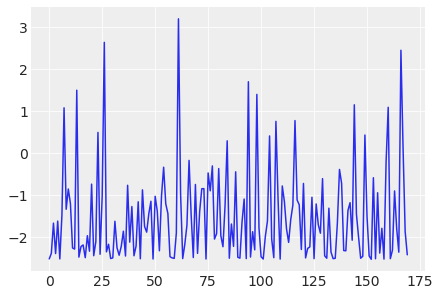

In [20]:
m_8_3_loo = az.loo(m_8_3_trace, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

## 8.1.4 Plotting the interaction

#### Code 8.17

In [21]:
m_8_3_posterior = az.extract_dataset(m_8_3_trace.posterior)

Text(0, 0.5, 'log GDP (as proportion of mean)')

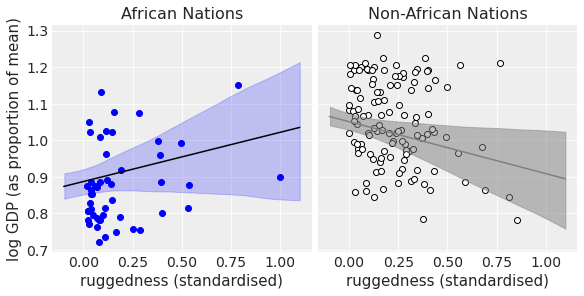

In [22]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

# extract posterior samples of parameters
a0 = m_8_3_posterior["a"][0, :].to_numpy()
a1 = m_8_3_posterior["a"][1, :].to_numpy()
b0 = m_8_3_posterior["b"][0, :].to_numpy()
b1 = m_8_3_posterior["b"][1, :].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred0 = a0 + rugged_plot.reshape(-1, 1) * b0
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred1 = a1 + rugged_plot.reshape(-1, 1) * b1
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")

# 8.2 Symmetry of interactions

- 布里丹的屁股是一个哲学问题，在这个问题中，一只总是朝着最近的一堆食物移动的屁股，当他发现自己在两堆相同的食物之间有相等的距离时，就会饿死。这是一个对称性问题：屁股如何在两个相同的选项中做出决定？
- 同样采用8.1的Ruggedness和GDP的例子，在这个例子中的Interaction可以按如下两种表述说明：
    - Ruggedness与logGDP之间的联系在多大程度上取决于这个国家是否在非洲？8.1.3&8.1.4便是这种解释
    - 非洲与logGDP之间的联系在多大程度上取决于Ruggedness？  
  
    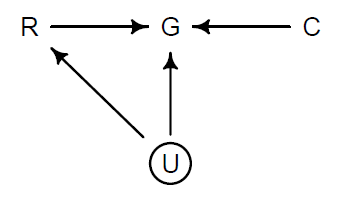
- the slope is conditional on continent
  $$\mu_i=\alpha_{\mathrm{CID}[i]}+\beta_{\mathrm{CID}[i]}(r_i-\bar{r})$$
- the intercept is conditional on ruggedness
  $$\mu_{i}=\underbrace{\left(2-\operatorname{CID}_{i}\right)\left(\alpha_{1}+\beta_{1}\left(r_{i}-\bar{r}\right)\right)}_{\operatorname{CID}[i]=1}+\underbrace{\left(\operatorname{CID}_{i}-1\right)\left(\alpha_{2}+\beta_{2}\left(r_{i}-\bar{r}\right)\right)}_{\operatorname{CID}[i]=2}$$

  $$\operatorname{CID}_{i}=1 \quad \text{Africa},\quad \operatorname{CID}_{i}=2 \quad \text{other continets} $$
   - It’ll be helpful to plot the reverse interpretation: 非洲与logGDP之间的联系在多大程度上取决于Ruggedness？ What we’ll do is compute the difference between a nation in Africa and outside Africa, holding its ruggedness constant.
   - 即控制ruggedness，看非洲国家与非非洲国家之间的差异，如Code8.18图所示
   - <font color=Blue>**(1) the influence of ruggedness depends upon continent and (2) the influence of continent depends upon ruggedness.**</font> <font color=Red>**这是一种对称**</font>

#### Code 8.18

(0.0, 1.0)

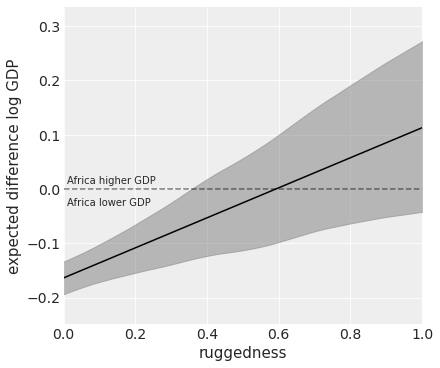

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_plot, delta.mean(1), c="k")
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)

These numbers are quite different from the book - not sure why.

# 8.3 Continuous interactions

- 8.1和8.2讲的是conditional on category，若conditional on continuous variables该怎么办呢？

## 8.3.1 A winter flower

- 这个例子中的数据是在不同的土壤和光照条件下，种植在温室里的郁金香花床上开花的大小
  - $\text{bed} \in (\text{a,b,c})$
  - water indicates one of three ordered levels of soil moisture, from low (1) to high (3)
  - shade indicates one of three ordered levels of light exposure, from high (1) to low (3)
- 既然光和水都有助于植物生长和开花，那么理所当然地，两者的独立作用将会产生更大的开花。但我们也会对这<font color=Blue>两个变量之间的相互作用感兴趣</font>
  - 例如，在没有光的情况下，很难看出水如何帮助植物——光合作用既依赖于光也依赖于水
  - 同样，在没有水的情况下，阳光对植物也没有什么好处
  - 对这种相互依赖进行建模的一种方法是使用交互效应(interaction effect)
  - 在缺乏一个良好的相互作用机制模型的情况下，一个简单的线性双向相互作用模型是一个很好的开始

#### Code 8.19

In [24]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


## 8.3.2 The models

### 1. 模型1：包含water和shade但无两者的交互作用，即仅包含主效应(main effects)

$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S})$$

#### Code 8.20: 数据预处理
- blooms_std ranges from 0 to 1, and both water_cent and shade_cent range from −1 to 1.

In [25]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

#### Code 8.21: 探索先验需要如何分布

In [26]:
a = stats.norm.rvs(0.5, 1, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.6092

#### Code 8.22: 探索先验需要如何分布

In [27]:
a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.0447

#### Code 8.23

In [28]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"].values + bs * d["shade_cent"].values
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_4_trace = pm.sample()
    m_8_4_post = az.extract_dataset(m_8_4_trace.posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


#### 2. 模型2：包含主效应(main effects)与交互效应(interaction effects)

- For example, if water is low, then decreasing the shade can’t help as much as when water is high. We want the slope of water, $\beta_W$, to be conditional on shade. Likewise for shade being conditional on water.
- <font color=Red>**那么该如何表示这种交互作用呢？**</font>
  - 在ruggedness和logGDP的例子中，采用的方法是将continent固定，看continnet与ruggedness的交互作用。但在这个例子中种类众多，且当某种变量是连续变量时这种方法是不可取的
  - When we have two variable, an outcome and a predictor, and we wish to model the mean of the outcome such that it is conditional on the value of a continuous predictor $x$, we can use a linear model: $\mu_i = \alpha + \beta x_i$
  - 采用这种思路：conditional on shade
    $$\begin{aligned}
    \mu_{i}& =\alpha + \gamma_{W,i} W_i + \beta_S S_i  \\
    \gamma_{W,i}& =\beta_W + \beta_W S_i 
    
    \end{aligned}$$
    - 可得  
  
      $$\mu_{i}  =\alpha+\underbrace{\left(\beta_{W}+\beta_{W S} S_{i}\right)}_{\gamma_{W, i}} W_{i}+\beta_{S} S_{i}=\alpha+\beta_{W} W_{i}+\beta_{S} S_{i}+\beta_{W S} S_{i} W_{i}$$
    - conditional on water可得到相同的结果
  - 因此模型变为
    $$B_i \sim Normal(\mu_i,\sigma)$$

    $$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S}) +\beta_{WS}W_iS_i $$
     - $\beta_{WS}$的先验分布与$\beta_W$一样，详见书

#### Code 8.24

In [29]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = (
        a
        + bw * d["water_cent"].values
        + bs * d["shade_cent"].values
        + bws * d["water_cent"].values * d["shade_cent"].values
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_5_trace = pm.sample()
    m_8_5_post = az.extract_dataset(m_8_5_trace.posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


## 8.3.3 Plotting posterior predictions

- Notice that the top model believes that water helps—there is a positive slope in each plot—and that shade hurts—the lines sink lower moving from left to right.But the slope with water doesn’t vary across shade levels.
- In the bottom row, the interaction is turned on. Now the model believes that the effect of water decreases as shade increases. The lines get flat

#### Code 8.25

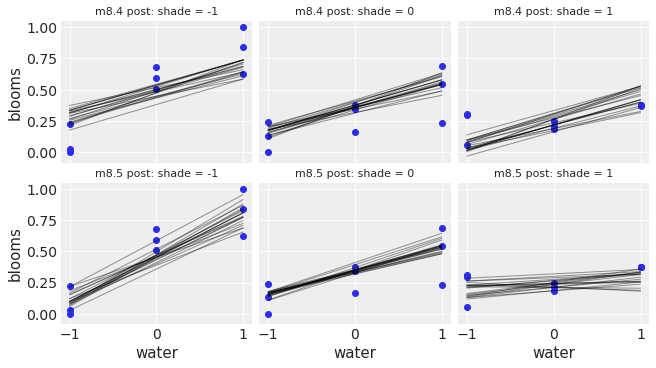

In [30]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_post["a"][:n_lines].to_numpy()
        + m_8_4_post["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_post["a"][:n_lines].to_numpy()
        + m_8_5_post["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"][:n_lines].to_numpy() * shade
        + m_8_5_post["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

## 8.3.4 Plotting prior predictions

- Code8.26可以给出一种非常粗略的观察
  - 位于上方的三张图三条粗线的斜率不随着shade变化而变化，未体现interaction
  - 位于下方的三张图三条粗线的斜率随着shade变化而变化，体现interaction

#### Code 8.26

In [31]:
with m_8_4:
    m_8_4_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])
    m_8_4_priors = az.extract_dataset(m_8_4_priors.prior)

with m_8_5:
    m_8_5_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])
    m_8_5_priors = az.extract_dataset(m_8_5_priors.prior)

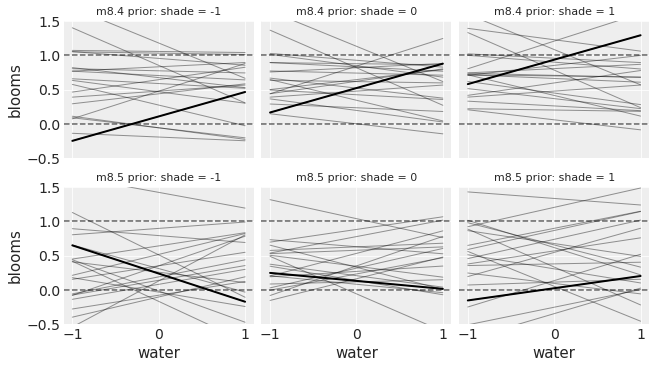

In [32]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_priors["a"][:n_lines].to_numpy()
        + m_8_4_priors["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_4_priors["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_priors["a"][:n_lines].to_numpy()
        + m_8_5_priors["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_5_priors["bs"][:n_lines].to_numpy() * shade
        + m_8_5_priors["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 05 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

matplotlib: 3.5.2
numpy     : 1.22.1
seaborn   : 0.11.2
pandas    : 1.4.2
scipy     : 1.7.3
pymc      : 4.0.0
arviz     : 0.12.1

Watermark: 2.3.1

